In [1]:
import probdiffeq.taylor as taylor
import jax
import jax.numpy as jnp

state = 1


def vf(y, *, t):
    du_dt = y[state : state * 2]
    dv_dt = -y[:state]
    return jnp.concatenate([du_dt, dv_dt])


tcoeffs = taylor.odejet_padded_scan(
    lambda y: vf(y, t=0), (jnp.asarray([1] * state + [0] * state),), num=4
)
jnp.array(tcoeffs)[:, :state]

Array([[ 1],
       [ 0],
       [-1],
       [ 0],
       [ 1]], dtype=int32)

yes [ 1.  0. -1. -0.  1.  0. -1. -0.  1.]
no [1. 0. 0. 0. 0. 0. 0. 0. 0.]


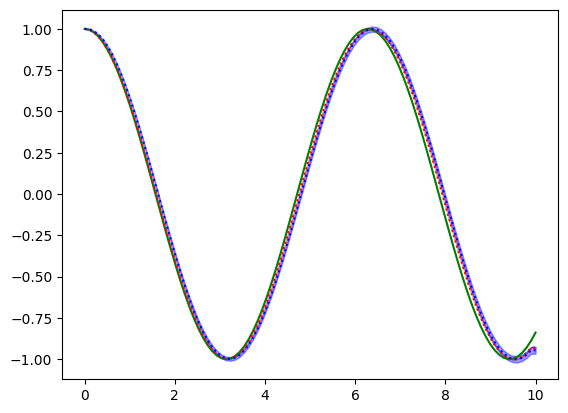

In [7]:
from probabilistic_numerics import kalman_filter as pn
import matplotlib.pyplot as plt

end_time = 10


def pn_solve_nonlinear_IVP(q, ax, timesteps, prior_name, prior_matrix):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(1.0)
    if prior_name == "yes":
        tcoeffs = taylor.odejet_padded_scan(
            lambda y: vf(y, t=0), (initial_mean[:2],), num=q
        )
        initial_mean = jnp.array(tcoeffs)[:, 0]

    print(prior_name, initial_mean)

    delta = end_time / timesteps

    def zero_obs(state, time, step):
        return jnp.array([state[0] + state[2]])

    _samples, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=prior_matrix,
        initial_mean=initial_mean,
        derivatives=q,
        timesteps=timesteps,
        delta_time=delta,
        prior=prior_name,
        observation_function=zero_obs,
        update_indicator=jnp.array([False] + [True] * (timesteps - 1)),
        observation_uncertainty=jnp.eye(1) * 0,
    )

    x_axis = jnp.linspace(0, end_time, 100)
    means = jnp.interp(
        x_axis, jnp.linspace(0, end_time, timesteps, endpoint=False), means[:, 0]
    )
    stds = jnp.interp(
        x_axis, jnp.linspace(0, end_time, timesteps, endpoint=False), stds[:, 0]
    )
    ax.plot(
        x_axis,
        means,
        label="PN EKF " + prior_name,
        linestyle="dotted",
        color="r" if prior_name == "yes" else "b",
    )
    ax.fill_between(
        x_axis,
        means - stds * 3,
        means + stds * 3,
        alpha=0.4,
        color="r" if prior_name == "yes" else "b",
    )


plt.gca().plot(
    jnp.linspace(0, end_time, 100),
    jnp.cos(jnp.linspace(0, end_time, 100)),
    label="True solution",
    color="g",
)
# pn_solve_nonlinear_IVP(5, plt.gca(), timesteps=20, prior_name="iwp", prior_matrix=[-1])
pn_solve_nonlinear_IVP(8, plt.gca(), timesteps=100, prior_name="yes", prior_matrix=[-1])
pn_solve_nonlinear_IVP(8, plt.gca(), timesteps=100, prior_name="no", prior_matrix=[-1])
# pn_solve_nonlinear_IVP(8, plt.gca(), timesteps=1000, prior_name="no", prior_matrix=[-1])
# pn_solve_nonlinear_IVP(2, plt.gca(), timesteps=20, prior_name="iwp", prior_matrix=[-1])